# Loki PredEx
This notebook demonstrates how to run *Loki PredEx* on the normal human heart dataset. It takes about 1 min to run this notebook on MacBook Pro.

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import os
import scipy.sparse

import loki.predex
sc.settings.set_figure_params(dpi=80, facecolor="white")

In [2]:
import loki.utils
import loki.preprocess
import torch
import torch.nn.functional as F
from typing import List, Tuple, Union
from PIL import Image
Image.MAX_IMAGE_PIXELS = None  # Disable DecompressionBombError

data_dir = './data'
model_path = os.path.join(data_dir, 'checkpoint.pt')
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'gpu' if loki.utils.is_gpu_available() else 'cpu'

/home/jamie.macdonald2/software/miniforge3/envs/loki-env/lib/python3.9/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [3]:
# def encode_texts(
#     model: torch.nn.Module,
#     tokenizer: callable,
#     texts: List[str],
#     device: Union[str, torch.device]
# ) -> torch.Tensor:
#     """
#     Batch–encode a list of strings into L2‑normalized embeddings.
#     Returns a tensor of shape (N, D).
#     EDIT - Jamie had to fix because the text was not transferred to the correct device before encoding.
#     """
#     # Tokenizer returns a dict of tensors
#     text_inputs = tokenizer(texts)
#     if isinstance(text_inputs, dict):
#         text_inputs = {k: v.to(device) for k, v in text_inputs.items()}
#     else:
#         text_inputs = text_inputs.to(device)
    
#     with torch.no_grad():
#         feats = model.encode_text(text_inputs).to(device)             # (N, D)
#     return F.normalize(feats, p=2, dim=-1)   

# def encode_text_df(
#     model: torch.nn.Module,
#     tokenizer: callable,
#     df: pd.DataFrame,
#     col_name: str,
#     device: Union[str, torch.device]
# ) -> torch.Tensor:
#     """
#     Encodes an entire DataFrame column into (N, D) embeddings.
#     """
#     texts = df[col_name].astype(str).tolist()
#     return encode_texts(model, tokenizer, texts, device)


We provide the image-ST similarity matrix generated from the OmiCLIP model.
The sample data and embeddings are stored in the directory `data/loki_predex/`, which can be donwloaded from [Google Drive link](https://drive.google.com/file/d/1aPK1nItsOEPxTihUAKMig-vLY-DMMIce/view?usp=sharing).

Here is a list of the files that are needed to run the ST gene expression prediction on the human heart dataset:
```
.
├── similarity_matrix
│   └── image_text_similarity.npy
├── training_data
│   ├── all_shared_genes.txt
│   ├── combined_expression_matrix.npy
│   ├── combined_obs.npy
│   └── train_df.csv
└── validation_data
    ├── HCAHeartST11702009.h5ad
    ├── top300_gene_list.npy
    └── val_df.csv                                   
```

In [4]:
# Create dictionaries to convert between Ensembl gene IDs and HGNC symbols
# conversion = pd.read_csv('../../../../tahsin/HEST/assets/gene_ids/hgnc_complete_set.txt', sep="\t").loc[:, ['ensembl_gene_id', 'symbol']]

conversion = pd.read_csv('/work/bose_lab/tahsin/HEST/assets/gene_ids/archive/human_hgnc_ensembl.txt', sep="\t").loc[:, ['Ensembl gene ID', 'Approved symbol']]
# print(conversion.columns)
# convert_to_ens = conversion.set_index('symbol')['ensembl_gene_id'].to_dict()
# convert_to_sym = conversion.set_index('ensembl_gene_id')['symbol'].to_dict()
convert_to_ens = conversion.set_index('Approved symbol')['Ensembl gene ID'].to_dict()
convert_to_sym = conversion.set_index('Ensembl gene ID')['Approved symbol'].to_dict()

In [5]:
convert_to_sym['ENSG00000281508'] = 'CDR1-AS' # Not already in dictionary
convert_to_sym['ENSG00000112096'] = 'SOD2'

# Training data 

I don't think we can use their training data. We need to create a similarity matrix with the image embeddings of each of the images they use, which we don't have.

In [6]:
# data_path = './data/loki_predex/' 
data_path = './loki_predex/' 

In [7]:
train_df = pd.read_csv(os.path.join(data_path, 'training_data', 'train_df.csv'), index_col=0)
combined_expression_array = np.load(os.path.join(data_path, 'training_data', 'combined_expression_matrix.npy'))

# Get the rows of the expression array (Has their training and validation data)
combined_obs_array = np.load(os.path.join(data_path,'training_data', 'combined_obs.npy'))

# Get desired spots
train_spots = train_df.index.tolist()

# Get the columns of the expression array:
with open(os.path.join(data_path, 'training_data', 'all_shared_genes.txt'), 'r') as f:
    shared_genes = [line.strip() for line in f]
    print("Shared genes:", shared_genes[:10])  # Print first 10 shared genes for verification

# Extract training spots 
train_indices = np.isin(combined_obs_array, train_spots) # list of spot ids that are in the training set
train_data = combined_expression_array[train_indices, :] # Extract the training expression data based on the indices

Shared genes: ['A1BG', 'A1CF', 'A2M', 'A2ML1', 'A3GALT2', 'A4GALT', 'A4GNT', 'AAAS', 'AACS', 'AADAC']


In [8]:
import json
json_file = json.load(open('data/HOUNKPE_HOUSEKEEPING_GENES.v2025.1.Hs.json', 'r'))
housekeeping_genes = json_file['HOUNKPE_HOUSEKEEPING_GENES']['geneSymbols']
# housekeeping_genes = [convert_to_sym[g] for g in housekeeping_genes if g in convert_to_sym]  # Convert to HGNC symbols
# If housekeeping_genes is a list of gene symbols:
housekeeping_genes_df = pd.DataFrame({'genesymbol': housekeeping_genes})
# Filter the training data to only include housekeeping genes

# Functions to Manipulate Data for Similarity Matrix

In [9]:
def emb_to_sym(label):
    """
    Convert the label to a list of gene symbols.
    """
    if isinstance(label, str):
        for gene in label.split(' '):
            if gene not in convert_to_sym and gene in convert_to_ens:
                # print(f"Already a symbol.")
                return label
            elif gene not in convert_to_sym:
                print(f"Error: {gene} not in conversion dictionary.")
            else:
                conversion = [convert_to_sym[gene] for gene in label.split(' ')]
                return ' '.join(conversion)
    elif isinstance(label, list):
        conversion = [convert_to_sym[gene] for gene in label]
        return ' '.join(conversion)
    else:
        return []
    

In [10]:
import h5py
def encode_patches(h5f_path, model, preprocess, device):
    """
    Encode patches from an HDF5 file.
    """
    with h5py.File(h5f_path, 'r') as h5f:
        images = h5f['img'][:]
        barcodes = h5f['barcode'][:]
    barcode_strings = [bc[0].decode('utf-8') if isinstance(bc[0], bytes) else bc[0] for bc in barcodes]
    image_embeddings = []
    for image, barcode in zip(images, barcode_strings):
        # ---- embedding steps taken from loki.predex.encode_images ----
        # Preprocess the image, then stack to create a batch of size 1
        image_input = torch.stack([preprocess(image)]).to(device)

        # Generate the image features without gradient tracking
        with torch.no_grad():
            image_features = model.encode_image(image_input)

        # Accumulate the feature embeddings in the list
        image_embeddings.append(image_features)

    # Convert the list of embeddings to a NumPy array, then to a PyTorch tensor
    image_embeddings = torch.cat(image_embeddings, dim=0)

    # Normalize all embeddings across the feature dimension (L2 normalization)
    image_embeddings = F.normalize(image_embeddings, p=2, dim=-1)

    return image_embeddings, barcode_strings


In [11]:
def make_similarity_df(train_ids, val_ids, model, preprocess, tokenizer, device, image = "patches", hest_path = "/work/bose_lab/tahsin/data/HEST"):
    """
    Generate a similarity matrix between image embeddings and gene text embeddings for given train and validation IDs.

    Args:
        train_ids (list): List of training sample IDs.
        val_ids (list): List of validation sample IDs.
        model: Model used for encoding images and texts.
        preprocess: Preprocessing function for images.
        tokenizer: Tokenizer for gene text.
        device (str or torch.device): Device to run computations on.
        image (str): Type of image input ("patches" or "wsis").
        hest_path (str): Path to HEST data directory.

    Returns:
        similarity_matrix (torch.Tensor): Similarity matrix of shape (num_val_patches, num_train_genes).
        barcodes (list): List of barcode strings for validation patches.
    """
    top_k_genes_str = pd.DataFrame(columns=['label'])
    for id in train_ids: # ASSUMING WE USE ST FROM TRAINING DATA, NOT PATCHES
        adata_path = os.path.join(hest_path, "st", id + ".h5ad")
        if os.path.exists(adata_path):
            adata = sc.read_h5ad(adata_path)
            print(f"Loaded {id} with shape {adata.shape}")
            
            # Print gene identifiers and spot identifiers
            print("Gene identifiers:", adata.var_names.tolist()[:10])  # Print first 10 gene identifiers
            print("Spot identifiers:", adata.obs_names.tolist()[:10])  # Print first 10 spot identifiers
        else:
            print(f"File not found: {adata_path}")
            continue
        todense = False
        if scipy.sparse.issparse(adata.X):
            todense = True
        gene_df = loki.preprocess.generate_gene_df(adata, housekeeping_genes_df, todense=todense)
        top_k_genes_str = pd.concat([top_k_genes_str, gene_df])
    pretty_top_k_genes_str = top_k_genes_str.copy()
    pretty_top_k_genes_str['label'] = pretty_top_k_genes_str['label'].apply(emb_to_sym)
    text_embeddings = loki.utils.encode_text_df(model, tokenizer, pretty_top_k_genes_str, 'label', device)
        # np.save(os.path.join(data_path, 'validation_data', id+'_top_k_text_embeddings.npy'), text_embeddings.cpu().numpy())
    
    for id in val_ids:
        if image == "wsis":
            image_path = os.path.join(hest_path, "wsis", id + ".tif")
            image_embeddings = loki.predex.encode_image(model, image_path, device)
        elif image == "patches":
            image_path = os.path.join(hest_path, "patches", id + ".h5")
            patch_embeddings, barcodes = encode_patches(image_path, model, preprocess, device)
            image_embeddings = patch_embeddings

    similarity_matrix = image_embeddings @ text_embeddings.T  # Compute similarity matrix
    
    return similarity_matrix, barcodes

In [12]:
def order_columns(ad, order):
    """
    Order the columns of an AnnData object based on a given order.
    """
    ad = ad[:, order]
    ad.var_names = order
    return ad

# Load Validation Data - HEST 

In [13]:
import os

hest_path = "/work/bose_lab/tahsin/data/HEST"

# Expand user (~) in the path
# hest_path_expanded = os.path.expanduser(hest_path)
hest_path_expanded = hest_path

if os.path.isdir(hest_path_expanded):
    print(f"Directory exists: {hest_path_expanded}")
else:
    print(f"Directory does not exist: {hest_path_expanded}")

Directory exists: /work/bose_lab/tahsin/data/HEST


## Metadata loading/investigation

In [14]:
import datasets

meta_df = pd.read_csv(os.path.join(hest_path, "HEST_v1_1_0.csv"))

# Filter the dataframe to only include rows where 'organ' is 'Heart'
meta_df = meta_df[(meta_df['organ'] == 'Heart') & (meta_df['species'] == 'Homo sapiens')]
print(meta_df.shape)

# Separate dataframe into training and validation sets
meta_df = meta_df.sample(frac=1, random_state=42)  # Shuffle the dataframe
train_frac = 0.8
train_size = int(len(meta_df) * train_frac)
train_df_80 = meta_df.iloc[:train_size]
val_df_20 = meta_df.iloc[train_size:]

(62, 28)


In [15]:
meta_df

dataset_title       id  \
346  A spatiotemporal organ-wide gene expression an...    SPA41   
352  A spatiotemporal organ-wide gene expression an...    SPA35   
39   Spatially resolved multiomics of human cardiac...  MISC142   
353  A spatiotemporal organ-wide gene expression an...    SPA34   
44   Spatially resolved multiomics of human cardiac...  MISC136   
..                                                 ...      ...   
215                                        Human Heart   TENX15   
53   Spatially resolved multiomics of human cardiac...  MISC127   
67   Spatially resolved multiomics of human cardiac...  MISC113   
347  A spatiotemporal organ-wide gene expression an...    SPA40   
77   Spatially resolved multiomics of human cardiac...  MISC103   

    image_filename  organ disease_state oncotree_code       species patient  \
346      SPA41.tif  Heart       Healthy           NaN  Homo sapiens     NaN   
352      SPA35.tif  Heart       Healthy           NaN  Homo sapiens     NaN   
39     MISC142.tif  Heart       Healthy           NaN  Homo sapiens           
353      SPA34.tif  Heart       Healthy           NaN  Homo sapiens     NaN   
44     MISC136.tif  Heart       Healthy           NaN  Homo sapiens           
..             ...    ...           ...           ...           ...     ...   
215     TENX15.tif  Heart       Healthy           NaN  Homo sapiens     NaN   
53     MISC127.tif  Heart       Healthy           NaN  Homo sapiens           
67     MISC113.tif  Heart       Healthy           NaN  Homo sapiens           
347      SPA40.tif  Heart       Healthy           NaN  Homo sapiens     NaN   
77     MISC103.tif  Heart       Healthy           NaN  Homo sapiens           

               st_technology data_publication_date  ... treatment_comment  \
346  Spatial Transcriptomics             16-Dec-19  ...               NaN   
352  Spatial Transcriptomics             16-Dec-19  ...               NaN   
39                    Visium                   NaN  ...               NaN   
353  Spatial Transcriptomics             16-Dec-19  ...               NaN   
44                    Visium                   NaN  ...               NaN   
..                       ...                   ...  ...               ...   
215                   Visium               6/23/20  ...               NaN   
53                    Visium                   NaN  ...               NaN   
67                    Visium                   NaN  ...               NaN   
347  Spatial Transcriptomics             16-Dec-19  ...               NaN   
77                    Visium                   NaN  ...               NaN   

    pixel_size_um_embedded pixel_size_um_estimated  magnification  \
346                    NaN                0.813183            20x   
352                    NaN                0.908417            20x   
39               31.750063                0.454959            40x   
353                    NaN                0.899465            20x   
44               31.750063                0.441822            40x   
..                     ...                     ...            ...   
215                    NaN                0.726844            20x   
53               31.750063                0.503460            20x   
67                     NaN                0.455927            40x   
347                    NaN                0.791424            20x   
77                     NaN                0.456621            40x   

     fullres_px_width  fullres_px_height                 tissue  \
346              9830               8602                  Heart   
352              9830               8602                  Heart   
39              18063              18100   right cardiac atrium   
353              9830               8602                  Heart   
44              17955              18186  atrioventricular node   
..                ...                ...                    ...   
215             13332              13332                  Heart 

In [16]:
train_ids = train_df_80['id']
val_ids = val_df_20['id']

In [17]:
print(conversion)

       Ensembl gene ID Approved symbol
0      ENSG00000121410            A1BG
1      ENSG00000268895        A1BG-AS1
2      ENSG00000268895        A1BG-AS1
3      ENSG00000268895        A1BG-AS1
4      ENSG00000148584            A1CF
...                ...             ...
74997  ENSG00000165591           FAAH2
74998  ENSG00000232022          FAAHP1
74999  ENSG00000162585          FAAP20
75000  ENSG00000131944          FAAP24
75001  ENSG00000131944          FAAP24

[75002 rows x 2 columns]


In [18]:
# conversion[conversion['Ensembl gene ID'].isin(gene_list)]

In [19]:
# gene_list

In [20]:
gene_lists = []
list_o_lists = []
for id in train_ids[:10]:
    adata_path = os.path.join(hest_path, "st", id + ".h5ad")
    if os.path.exists(adata_path):
        print(f"="*50)
        adata = sc.read_h5ad(adata_path)
        print(f"Loaded {id} with shape {adata.shape}")
        print(f"Variable names: {adata.var.index[:5]}")
        gene_list = adata.var_names.tolist()
        print(f"Before striping: {gene_list[:3]}")
        gene_list = [gene.split('.')[0] if '.' in gene else gene for gene in gene_list]
        matches_df = conversion[conversion['Ensembl gene ID'].isin(gene_list)]['Approved symbol'].unique()
        if matches_df.shape[0] == 0:
            print(f"Matching genes found for {len(gene_list)}: {matches_df.shape[0]}")
        else:
            print(gene_list)

        
        # gene_list = [emb_to_sym(gene) for gene in gene_list if gene.startswith("ENSG")]
        # misfits = [gene for gene in gene_list if not gene in convert_to_sym]
        # print(len(misfits))
        # str = ' '.join(gene_list)
        # gene_lists.append(str)
        # list_o_lists.append(gene_list)

        # Print gene identifiers and spot identifiers
        # print("Gene identifiers:", adata.var_names.tolist()[:10])  # Print first 10 gene identifiers
        # print("Spot identifiers:", adata.obs_names.tolist()[:10])  # Print first 10 spot identifiers

Loaded SPA41 with shape (186, 39739)
Variable names: Index(['ENSG00000000003.14', 'ENSG00000000005.5', 'ENSG00000000419.12',
       'ENSG00000000457.13', 'ENSG00000000460.16'],
      dtype='object')
Before striping: ['ENSG00000000003.14', 'ENSG00000000005.5', 'ENSG00000000419.12']
['ENSG00000000003', 'ENSG00000000005', 'ENSG00000000419', 'ENSG00000000457', 'ENSG00000000460', 'ENSG00000000938', 'ENSG00000000971', 'ENSG00000001036', 'ENSG00000001084', 'ENSG00000001167', 'ENSG00000001460', 'ENSG00000001461', 'ENSG00000001497', 'ENSG00000001561', 'ENSG00000001617', 'ENSG00000001626', 'ENSG00000001629', 'ENSG00000001630', 'ENSG00000001631', 'ENSG00000002016', 'ENSG00000002079', 'ENSG00000002330', 'ENSG00000002549', 'ENSG00000002586', 'ENSG00000002587', 'ENSG00000002726', 'ENSG00000002745', 'ENSG00000002746', 'ENSG00000002822', 'ENSG00000002834', 'ENSG00000002919', 'ENSG00000002933', 'ENSG00000003056', 'ENSG00000003096', 'ENSG00000003137', 'ENSG00000003147', 'ENSG00000003249', 'ENSG000000033

In [21]:
all_genes = set(gene_lists)
print(f"Number of unique gene lists: {len(all_genes)}")
for idx, gene_list in enumerate(all_genes, 1):
    print(f"List {idx}: {gene_list[:200]}...")   # print only the first 100 chars
    
    

Number of unique gene lists: 0


In [22]:
all_genes_list = [gene_list.split(' ') for gene_list in gene_lists]
intersection_genes = list(set(all_genes_list[0]) & set(all_genes_list[1]))
for lst in all_genes_list[2:]:
    intersection_genes = list(set(intersection_genes) & set(lst))
print(f"Number of intersection genes: {len(intersection_genes)}")

IndexError: list index out of range

In [ ]:
model, preprocess, tokenizer = loki.utils.load_model(model_path, device)

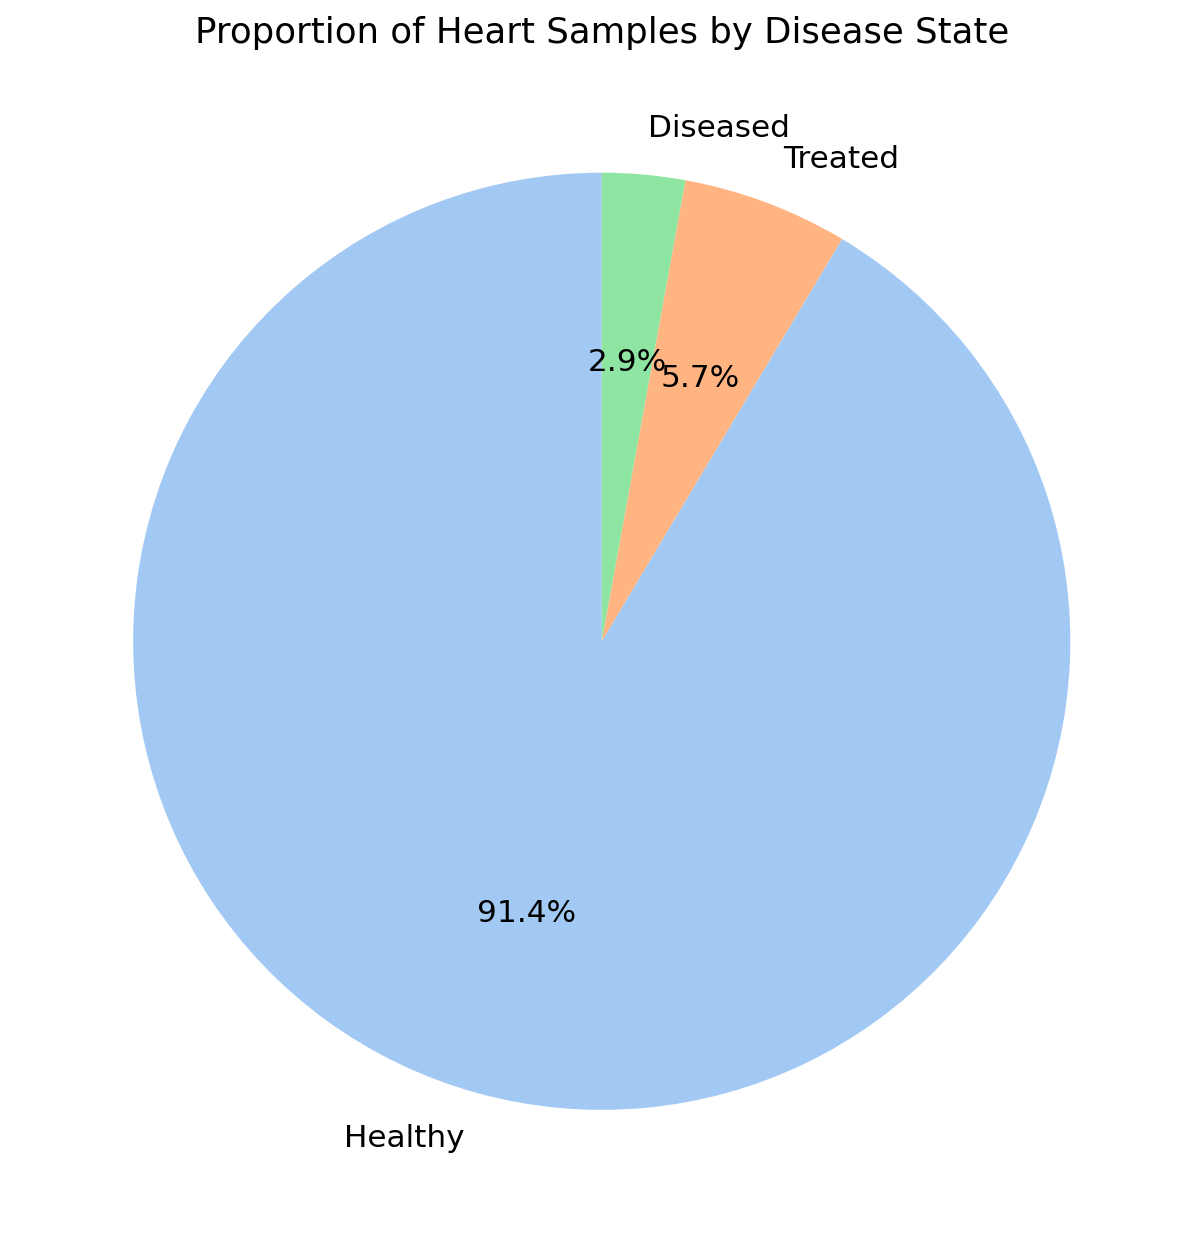

In [ ]:
import seaborn as sns

import matplotlib.pyplot as plt

# Count the number of samples for each disease_state
disease_counts = meta_df['disease_state'].value_counts(dropna=False)

# Prepare data for seaborn
disease_df = disease_counts.reset_index()
disease_df.columns = ['disease_state', 'count']

# Create a color palette
colors = sns.color_palette('pastel')[0:len(disease_df)]

# Plot pie chart
plt.figure(figsize=(8, 8))
plt.pie(
    disease_df['count'],
    labels=disease_df['disease_state'],
    autopct='%1.1f%%',
    startangle=90,
    colors=colors,
    textprops={'fontsize': 14}
)
plt.title('Proportion of Heart Samples by Disease State', fontsize=16)
plt.tight_layout()
plt.show()

The metadata file has the same info as the csv.

# Load Training Data

In [ ]:
def get_expressions(ids):
    """
    Get the expressions for the given ids.
    """
    expressions = []
    for id in ids:
        adata_path = os.path.join(hest_path, "st", id + ".h5ad")
        if os.path.exists(adata_path):
            adata = sc.read_h5ad(adata_path)
            expressions.append(adata.X.toarray())
        else:
            print(f"File not found: {adata_path}")
            expressions.append(None)
    return expressions

# Calculate Similarity and Predict

In [ ]:
image_text_similarity, barcodes = make_similarity_df(train_ids[:3], val_ids[:4], model, preprocess, tokenizer, device, image="patches")

Loaded MISC119 with shape (3448, 33538)
Gene identifiers: ['ENSG00000243485', 'ENSG00000237613', 'ENSG00000186092', 'ENSG00000238009', 'ENSG00000239945', 'ENSG00000239906', 'ENSG00000241599', 'ENSG00000236601', 'ENSG00000284733', 'ENSG00000235146']
Spot identifiers: ['AAACAACGAATAGTTC-1', 'AAACAGAGCGACTCCT-1', 'AAACAGCTTTCAGAAG-1', 'AAACAGGGTCTATATT-1', 'AAACCACTACACAGAT-1', 'AAACCGGAAATGTTAA-1', 'AAACCGGGTAGGTACC-1', 'AAACCGTTCGTCCAGG-1', 'AAACCTAAGCAGCCGG-1', 'AAACCTCATGAAGTTG-1']
Loaded MISC142 with shape (1302, 33538)
Gene identifiers: ['ENSG00000243485', 'ENSG00000237613', 'ENSG00000186092', 'ENSG00000238009', 'ENSG00000239945', 'ENSG00000239906', 'ENSG00000241599', 'ENSG00000236601', 'ENSG00000284733', 'ENSG00000235146']
Spot identifiers: ['AAACATTTCCCGGATT-1', 'AAACCTAAGCAGCCGG-1', 'AAACGAGACGGTTGAT-1', 'AAACGGGCGTACGGGT-1', 'AAACGGTTGCGAACTG-1', 'AAACTCGGTTCGCAAT-1', 'AAACTGCTGGCTCCAA-1', 'AAAGTGCCATCAATTA-1', 'AAAGTGTGATTTATCT-1', 'AAAGTTGACTCCCGTA-1']
Loaded SPA42 with shape 

AttributeError: 'ArrayView' object has no attribute 'todense'

In [ ]:
predicted_image_text_matrix = loki.predex.predict_st_gene_expr(image_text_similarity, train_data)
# predicted_image_text_matrix = predict_st_gene_expr(image_text_similarity, train_data)
prediction = pd.DataFrame(predicted_image_text_matrix, index=barcodes,columns=shared_genes)
predict_data = prediction[genelist]
predict_data = predict_data.loc[ad.obs_names]
predict_data

# Leftover

In [ ]:
import subprocess
import open_clip

model_name='coca_ViT-L-14'
pretrained_weight_path='path to the omiclip pretrained weight'
train_csv = 'visium_data/finetune_data.csv'
name = 'finetune_tnbc'

train_command = [
    'python', '-m', 'training.main',
    '--name', name,
    '--save-frequency', '5',
    '--zeroshot-frequency', '10',
    '--report-to', 'wandb',
    '--train-data', train_csv,
    '--csv-img-key', 'img_path',
    '--csv-caption-key', 'label',
    '--warmup', '10',
    '--batch-size', '64',
    '--lr', '5e-6',
    '--wd', '0.1',
    '--epochs', '10',
    '--workers', '16',
    '--model', model_name,
    '--csv-separator', ',',
    '--pretrained', pretrained_weight_path,
    '--lock-text-freeze-layer-norm',
    '--lock-image-freeze-bn-stats',
    '--coca-caption-loss-weight','0',
    '--coca-contrastive-loss-weight','1',
    '--val-frequency', '10',
    '--aug-cfg', 'color_jitter=(0.32, 0.32, 0.32, 0.08)', 'color_jitter_prob=0.5', 'gray_scale_prob=0'
]

subprocess.run(train_command)

(1302, 160)


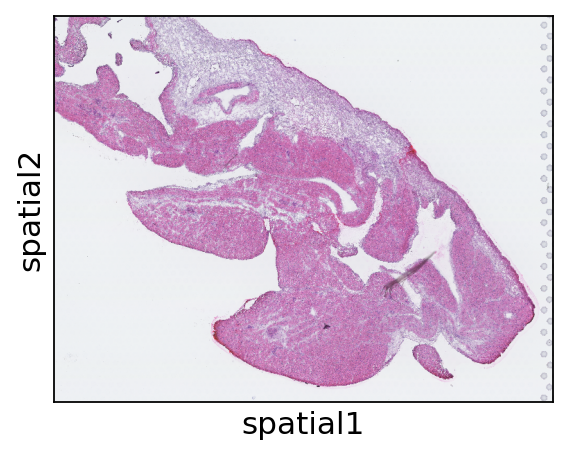

In [ ]:
# Load the AnnData object for the test id
data_path = './loki_predex'
adata = sc.read_h5ad(os.path.join(hest_path, "st", test_id + ".h5ad"))

# top 300 genes in the validation data
genelist = list(np.load(os.path.join(data_path, 'validation_data', 'top300_gene_list.npy'),allow_pickle=True))
ensembl_genelist = [convert_to_ens[g] for g in genelist if g in convert_to_ens]

# Get the top 300 genes by mean expression in adata
mean_expression = np.asarray(adata.X.mean(axis=0)).flatten()
top300_idx = np.argsort(mean_expression)[-300:][::-1]
top300_genes = adata.var_names[top300_idx]

# Common genes between the top 300 genes in adata and the validation data
common_genes_ens = list(set(top300_genes).intersection(ensembl_genelist))
common_genes_sym = [convert_to_sym[gene] for gene in common_genes_ens if gene in convert_to_sym]

# Filter adata to only include the common genes
ad = adata[:, adata.var_names.isin(common_genes_ens)]
print(f"Number of spots in adata: {ad.shape[0]}, Number of genes: {ad.shape[1]}")

# The image:
sc.pl.spatial(adata, img_key="downscaled_fullres", show=True, spot_size=10)
# print(ad.obs.columns)
# print(ad.uns['spatial']['ST']['images'].keys())

## Get image for validation set

In [ ]:
ad.X=ad.layers['original'] 
sc.pl.spatial(ad, img_key="hires", color='MYH7', size=1.5, vmax='p90', vmin='p10', title='Ground Truth MYH Expression')

In [ ]:
ad.X = ad.layers['loki']
sc.pl.spatial(ad, img_key="hires", color='MYH7', size=1.5, vmax='p90', vmin='p10', title='Loki Predicted MYH Expression')